# Tesis de Licenciatura en Astronomía

## Manuel López Vargas

# Detección de señales en series de tiempo astronómicas utilizando algoritmos de Machine Learning

In [524]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as signal
from astropy.timeseries import LombScargle
from gatspy.periodic import LombScargleFast
from gatspy import datasets, periodic

In [515]:
rng = np.random.default_rng()

In [573]:
A = 3
B = 3
C = 4
w1 = 3.2 #rad/sec
w2 = 2.3 #rad/sec
w3 = 2.9 #rad/sec
psi1 = 1. #rad
psi2 = 1.8 #rad
n_in = 150
n_out = 100000

Generamos aleatoriamente tiempos de muestreo.

In [574]:
t = rng.uniform(0, 10*np.pi, n_in) 

Ploteamos dos ondas sinusoidales con freciencias diferentes ($\frac{w1}{w2}\neq Q$) para los tiempos seleccionados.

In [588]:
x = A * np.sin(w1*t + psi1) + B * np.sin(w2*t + psi2) 

Definimos un arreglo de frecuencias para el que se calculará el periodograma

In [589]:
w = np.linspace(0.01, 10, n_out)
periods = 2 * np.pi / w

Calculo el Lomb-Scargle periodograma

In [590]:
pgram = signal.lombscargle(t, x, w, normalize=True)

Ploteo los datos de salida

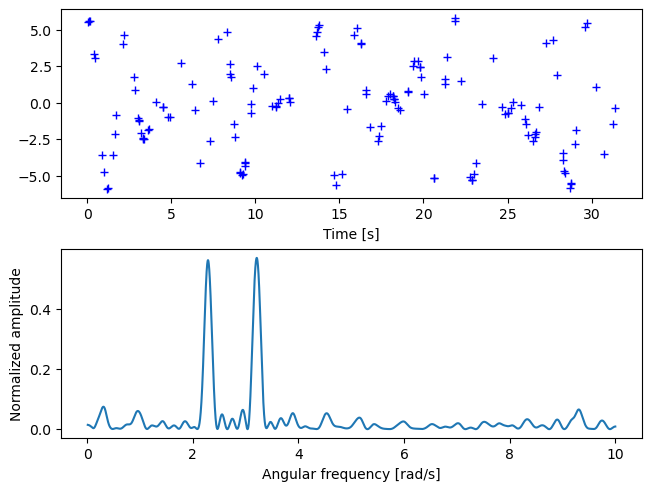

In [591]:
fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
ax_t.plot(t, x, 'b+')
ax_t.set_xlabel('Time [s]')

#Luego ploteo el periodograma normalizado

ax_w.plot(w, pgram)
ax_w.set_xlabel('Angular frequency [rad/s]')
ax_w.set_ylabel('Normalized amplitude')
plt.show();

Los resultados no cambian cuando $(\frac{w1}{w2}= Q)$

Probamos con otro código.

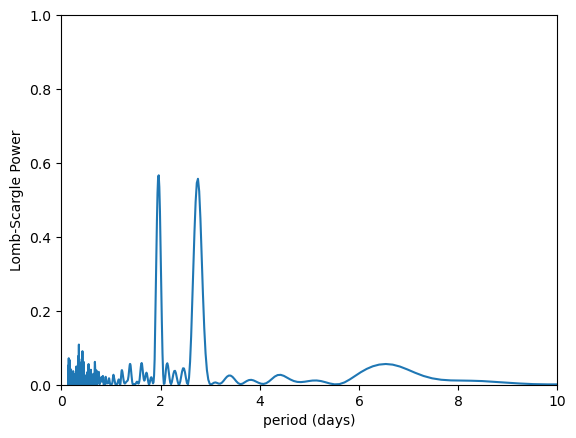

In [592]:
model = LombScargleFast().fit(t, x)
periods, power = model.periodogram_auto(nyquist_factor)

fig, ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 10), ylim=(0, 1.0),
        xlabel='period (days)',
        ylabel='Lomb-Scargle Power');

In [593]:
#Definimos el rango de periodos donde queremos encontrar un pico.

f_in = 2.5 #limite infererior del intervalo
f_end = 3.2 #limite superior del intervalo

model = periodic.LombScargleFast(fit_period=True)
model.optimizer.set(period_range=(f_in,f_end), first_pass_coverage=10)
model.fit(t, x)          
period = model.best_period
nu = 2 * np.pi / period
print('La frecuencia encontrada es:',nu)

Finding optimal frequency:
 - Estimated peak width = 0.2
 - Using 10 steps per peak; omega_step = 0.02
 - User-specified period range:  2.5 to 3.2
 - Computing periods at 29 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 495 steps
La frecuencia encontrada es: 2.301764362920743


#### Calculamos la False-Alarm Probablility (FAP).

La FAP se define como FAP(z) = $1 - [P_{single0}(z)]^{N_{eff.}}$ donde $N_{eff.}= f_{max}T$

Utilizando la libreria astropy.timeseries vamos a calcular la FAP.

In [594]:
ls = LombScargle(t, x, normalization='standard')
power = ls.power(w)
print(power.max())  

0.5691154553066237


In [595]:
fap = ls.false_alarm_probability(power.max())  
print('FAP =', fap)

FAP = 5.090845778674334e-24


Lo que esto nos dice es que, suponiendo que no haya una señal periódica en los datos, observaremos un pico tan alto o más con una probabilidad de $3.118\ x10^{-22}$, lo que nos da una fuerte indicación de que hay una señal periódica presente en los datos.

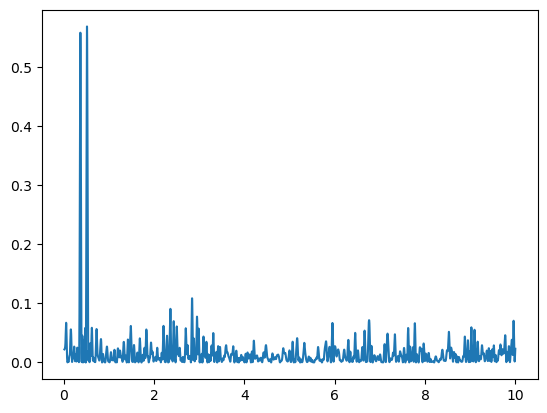

In [596]:
plt.plot(w,power);

In [597]:
probabilities = [ 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)  

array([0.11956825, 0.12864355, 0.14872932])

Esto nos indica que para alcanzar una probabilidad de falsa alarma del 10% es necesario que el pico más alto del periodograma sea aproximadamente 0,119; para el 5%, 0,129, y para el 1%, 0,149.

### Ahora simularemos nuestros datos utilizando un potencial con simetria esférica.

Probamos primero con el siguiente potencial:

### $\phi(r) = \frac{GM}{r} $

Luego

### $\ddot{x} = - \nabla \phi(r)$

Podemos descomponer esta ecuación diferencial de segundo orden en dos ecuaciones de primer orden.

### $\dot{x} = v\ \ \ ,\ \ \dot{x}(0) = \dot{x}_0$
### $\dot{v} = -\nabla \phi\ \ \ , \ \ x(0) = x_0$